##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generate music with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/music_generation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows you how to generate musical notes using a simple recurrent neural network (RNN). You will train a model using a collection of piano MIDI files from the [MAESTRO dataset](https://magenta.tensorflow.org/datasets/maestro). Given a sequence of notes, your model will learn to predict the next note in the sequence. You can generate longer sequences of notes by calling the model repeatedly.

This tutorial contains complete code to parse and create MIDI files. You can learn more about how RNNs work by visiting the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial.

## Setup

This tutorial uses the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [ ]:
!sudo apt install -y fluidsynth

In [1]:
!pip install --upgrade pyfluidsynth

In [2]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.4 MB/s  0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'pretty_midi' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pretty_midi'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592298 sha256=79de2fe6b06a7577c7a168aae363b269407959b477c52ebaab8a98f4ea2e9688
  Stored in directory: /home/rricca/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pretty_midi]


In [9]:
!pip3 install -U numpy grpcio absl-py py-cpuinfo psutil portpicker six mock requests gast h5py astor termcolor protobuf keras-applications keras-preprocessing wrapt google-pasta setuptools testresources pandas seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 61.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 62.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 65.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [seaborn]m7/8 [seaborn]ib]


In [12]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [13]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the Maestro dataset

In [ ]:
data_dir = pathlib.Path('data/maestro-v2_extracted/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

  3318865920/109945081707 ━━━━━━━━━━━━━━━━━━━━ 24:47 0us/step

The dataset contains about 1,200 MIDI files.

In [4]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file

First, use ```pretty_midi``` to parse a single MIDI file and inspect the format of the notes. If you would like to download the MIDI file below to play on your computer, you can do so in colab by writing ```files.download(sample_file)```.


In [5]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2_extracted/maestro-v2.0.0/2004/MIDI-Unprocessed_XP_19_R2_2004_01_ORIG_MID--AUDIO_19_R2_2004_03_Track03_wav.midi


Generate a `PrettyMIDI` object for the sample MIDI file.

In [6]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file. The playback widget may take several seconds to load.

In [7]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [8]:
display_audio(pm)

Do some inspection on the MIDI file. What kinds of instruments are used?

In [9]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [10]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=63, note_name=D#4, duration=0.1354
1: pitch=48, note_name=C3, duration=0.2698
2: pitch=75, note_name=D#5, duration=0.3531
3: pitch=55, note_name=G3, duration=0.1500
4: pitch=77, note_name=F5, duration=0.1000
5: pitch=50, note_name=D3, duration=0.0688
6: pitch=65, note_name=F4, duration=0.0708
7: pitch=55, note_name=G3, duration=0.1187
8: pitch=79, note_name=G5, duration=0.0521
9: pitch=67, note_name=G4, duration=0.0594


You will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number.
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times.


Extract the notes from the sample MIDI file.

In [11]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [12]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,75,1.037500,1.390625,0.000000,0.353125
1,63,1.073958,1.209375,0.036458,0.135417
2,48,1.091667,1.361458,0.017708,0.269792
3,55,1.323958,1.473958,0.232292,0.150000
4,77,1.481250,1.581250,0.157292,0.100000


It may be easier to interpret the note names rather than the pitches, so you can use the function below to convert from the numeric pitch values to note names.
The note name shows the type of note, accidental and octave number
(e.g. C#4).

In [13]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D#5', 'D#4', 'C3', 'G3', 'F5', 'D3', 'F4', 'G3', 'G5', 'D#3'],
      dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes

In [14]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

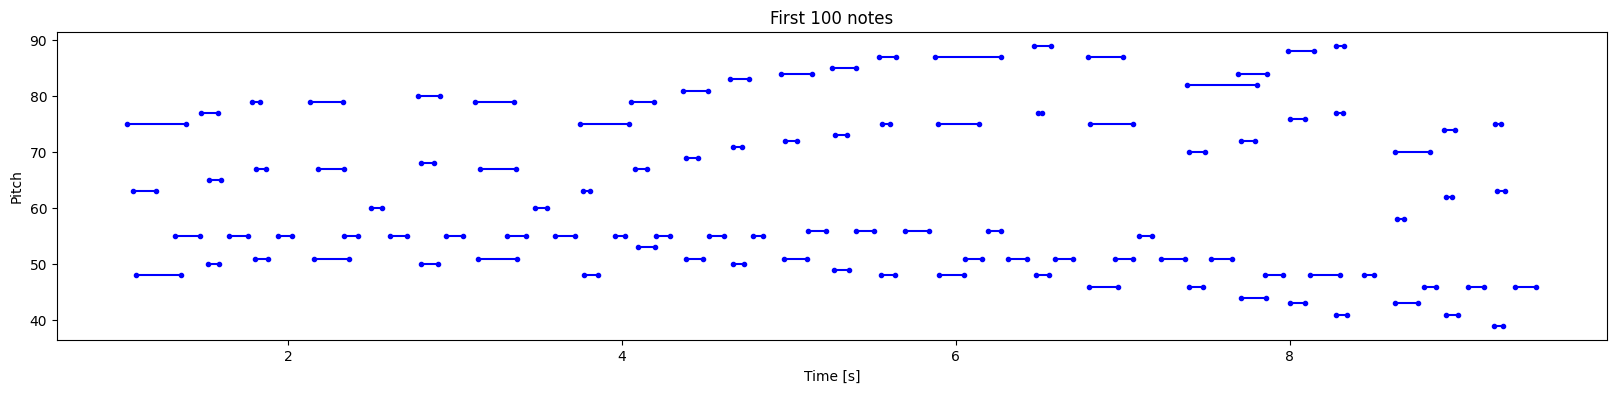

In [15]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

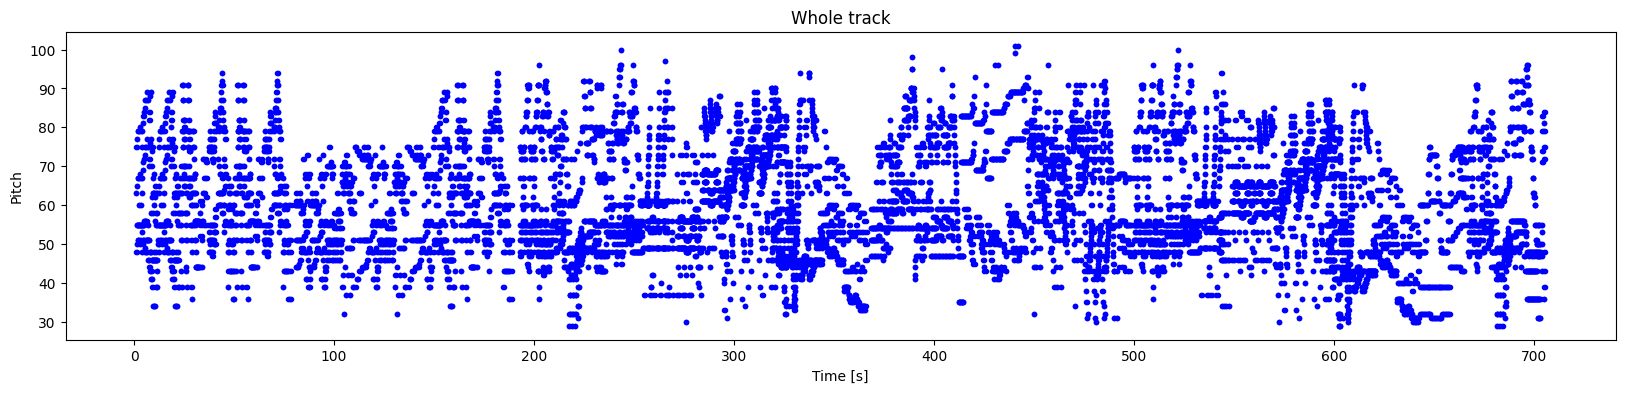

In [16]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [17]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

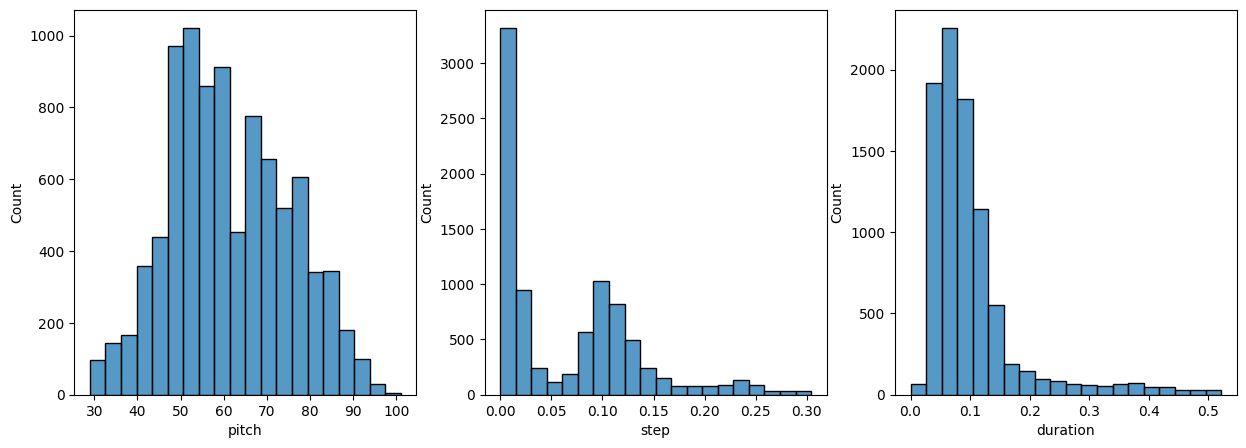

In [18]:
plot_distributions(raw_notes)

## Create a MIDI file

You can generate your own MIDI file from a list of notes using the function below.

In [19]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [20]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [21]:
display_audio(example_pm)

As before, you can write ```files.download(example_file)``` to download and play this file.

## Create the training dataset


Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [22]:
num_files = 20
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [23]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 140858


Next, create a `tf.data.Dataset` from the parsed notes.

In [24]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [25]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

2025-08-30 22:21:20.986354: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-30 22:21:21.127777: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-30 22:21:21.127926: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-30 22:21:21.129827: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-30 22:21:21.129999: I external/local_xla/xla/stream_executor

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

You will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence. You can find a diagram describing this process (and more details) in [Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

You can use the handy [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) function with size `seq_length` to create the features and labels in this format.

In [26]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [27]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [28]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.265625   0.         2.96041667]
 [0.3203125  0.090625   3.66354167]
 [0.359375   0.10729167 1.428125  ]
 [0.390625   0.09895833 0.29583333]
 [0.4140625  0.14166667 0.246875  ]
 [0.453125   0.14270833 0.37083333]
 [0.578125   4.959375   1.44583333]
 [0.5859375  1.35208333 0.19791667]
 [0.6015625  0.196875   0.42916667]
 [0.390625   1.55625    0.52395833]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=60.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.00729166666666714>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.689583333333335>}


2025-08-30 22:21:22.014743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Batch the examples, and configure the dataset for performance.

In [29]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE)
           )

In [30]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [31]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [32]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     67,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

Testing the `model.evaluate` function, you can see that the `pitch` loss is significantly greater than the `step` and `duration` losses.
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [33]:
losses = model.evaluate(train_ds, return_dict=True)
losses

2025-08-30 22:21:35.992741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 78700 of 140833
2025-08-30 22:21:43.962092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-08-30 22:21:43.970813: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 90300


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - duration_loss: 0.2137 - loss: 5.1070 - pitch_loss: 4.8536 - step_loss: 0.0398


2025-08-30 22:21:55.958280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:21:55.958377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/rricca/mlearn/tfgpu/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


{'duration_loss': 0.21367041766643524,
 'loss': 5.107025623321533,
 'pitch_loss': 4.853550434112549,
 'step_loss': 0.0397961251437664}

One way balance this is to use the `loss_weights` argument to compile:

In [34]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [35]:
model.evaluate(train_ds, return_dict=True)

2200/2200 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - duration_loss: 0.2137 - loss: 0.4961 - pitch_loss: 4.8536 - step_loss: 0.0398


2025-08-30 22:22:07.313628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:22:07.313734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_8]]
2025-08-30 22:22:07.313787: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7150954554009658250


{'duration_loss': 0.21367041766643524,
 'loss': 0.49614426493644714,
 'pitch_loss': 4.853550434112549,
 'step_loss': 0.0397961251437664}

Train the model.

In [36]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [37]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
2200/2200 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - duration_loss: 0.0841 - loss: 0.3232 - pitch_loss: 4.0313 - step_loss: 0.0376
Epoch 2/50
   6/2200 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - duration_loss: 0.1399 - loss: 0.3592 - pitch_loss: 3.9847 - step_loss: 0.0201

2025-08-30 22:22:35.281203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:22:35.281320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0816 - loss: 0.3144 - pitch_loss: 3.9260 - step_loss: 0.0365
Epoch 3/50


2025-08-30 22:22:59.428050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:22:59.428119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - duration_loss: 0.0796 - loss: 0.3105 - pitch_loss: 3.9139 - step_loss: 0.0352
Epoch 4/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.1234 - loss: 0.3416 - pitch_loss: 3.9353 - step_loss: 0.0214

2025-08-30 22:23:40.211254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:23:40.211328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0776 - loss: 0.3072 - pitch_loss: 3.9014 - step_loss: 0.0345
Epoch 5/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - duration_loss: 0.1116 - loss: 0.3294 - pitch_loss: 3.9324 - step_loss: 0.0212

2025-08-30 22:24:04.268949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:24:04.269013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0761 - loss: 0.3041 - pitch_loss: 3.8854 - step_loss: 0.0337
Epoch 6/50
   6/2200 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - duration_loss: 0.1223 - loss: 0.3426 - pitch_loss: 3.9285 - step_loss: 0.0239

2025-08-30 22:24:28.462243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:24:28.462318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0758 - loss: 0.3023 - pitch_loss: 3.8609 - step_loss: 0.0335
Epoch 7/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.1092 - loss: 0.3231 - pitch_loss: 3.8933 - step_loss: 0.0192

2025-08-30 22:24:52.588025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:24:52.588169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0741 - loss: 0.2982 - pitch_loss: 3.8345 - step_loss: 0.0324
Epoch 8/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - duration_loss: 0.1197 - loss: 0.3365 - pitch_loss: 3.8734 - step_loss: 0.0231

2025-08-30 22:25:16.719892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:25:16.719961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0736 - loss: 0.2970 - pitch_loss: 3.8248 - step_loss: 0.0321
Epoch 9/50
   6/2200 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - duration_loss: 0.1029 - loss: 0.3217 - pitch_loss: 3.8507 - step_loss: 0.0263

2025-08-30 22:25:40.901123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:25:40.901195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0725 - loss: 0.2946 - pitch_loss: 3.8093 - step_loss: 0.0316
Epoch 10/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0966 - loss: 0.3081 - pitch_loss: 3.8326 - step_loss: 0.0198

2025-08-30 22:26:05.134354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:26:05.134429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0716 - loss: 0.2929 - pitch_loss: 3.8010 - step_loss: 0.0312
Epoch 11/50
   6/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.1003 - loss: 0.3107 - pitch_loss: 3.8188 - step_loss: 0.0194

2025-08-30 22:26:29.275728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:26:29.275819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0716 - loss: 0.2924 - pitch_loss: 3.7958 - step_loss: 0.0310
Epoch 12/50
   6/2200 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - duration_loss: 0.1014 - loss: 0.3102 - pitch_loss: 3.8266 - step_loss: 0.0175

2025-08-30 22:26:53.645522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:26:53.645600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0699 - loss: 0.2894 - pitch_loss: 3.7833 - step_loss: 0.0303
Epoch 13/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0982 - loss: 0.3087 - pitch_loss: 3.7871 - step_loss: 0.0212

2025-08-30 22:27:17.974668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:27:17.974743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0695 - loss: 0.2881 - pitch_loss: 3.7780 - step_loss: 0.0297
Epoch 14/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0955 - loss: 0.3045 - pitch_loss: 3.7814 - step_loss: 0.0200

2025-08-30 22:27:42.335720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:27:42.335793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0682 - loss: 0.2862 - pitch_loss: 3.7700 - step_loss: 0.0295
Epoch 15/50
   6/2200 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - duration_loss: 0.0993 - loss: 0.3103 - pitch_loss: 3.7982 - step_loss: 0.0211

2025-08-30 22:28:06.695735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:28:06.695805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0666 - loss: 0.2834 - pitch_loss: 3.7626 - step_loss: 0.0287
Epoch 16/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0969 - loss: 0.3040 - pitch_loss: 3.7718 - step_loss: 0.0185

2025-08-30 22:28:30.932568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:28:30.932640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0673 - loss: 0.2842 - pitch_loss: 3.7627 - step_loss: 0.0288
Epoch 17/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0956 - loss: 0.3046 - pitch_loss: 3.7624 - step_loss: 0.0209

2025-08-30 22:28:55.079490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:28:55.079586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - duration_loss: 0.0653 - loss: 0.2805 - pitch_loss: 3.7513 - step_loss: 0.0276
Epoch 18/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0894 - loss: 0.2949 - pitch_loss: 3.7525 - step_loss: 0.0178

2025-08-30 22:29:19.589145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:29:19.589228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0665 - loss: 0.2818 - pitch_loss: 3.7512 - step_loss: 0.0277
Epoch 19/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0888 - loss: 0.2963 - pitch_loss: 3.7658 - step_loss: 0.0192

2025-08-30 22:29:44.004801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:29:44.004873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0651 - loss: 0.2806 - pitch_loss: 3.7556 - step_loss: 0.0278
Epoch 20/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0930 - loss: 0.3043 - pitch_loss: 3.7756 - step_loss: 0.0225

2025-08-30 22:30:08.286164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:30:08.286278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0643 - loss: 0.2788 - pitch_loss: 3.7449 - step_loss: 0.0272
Epoch 21/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0941 - loss: 0.2991 - pitch_loss: 3.7513 - step_loss: 0.0175

2025-08-30 22:30:32.720294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:30:32.720376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0639 - loss: 0.2768 - pitch_loss: 3.7363 - step_loss: 0.0260
Epoch 22/50
   6/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0959 - loss: 0.2992 - pitch_loss: 3.7713 - step_loss: 0.0147

2025-08-30 22:30:57.138678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:30:57.138754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0624 - loss: 0.2749 - pitch_loss: 3.7345 - step_loss: 0.0258
Epoch 23/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - duration_loss: 0.0858 - loss: 0.2906 - pitch_loss: 3.7231 - step_loss: 0.0186

2025-08-30 22:31:21.618183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:31:21.618261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0617 - loss: 0.2738 - pitch_loss: 3.7319 - step_loss: 0.0255
Epoch 24/50
   6/2200 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - duration_loss: 0.0895 - loss: 0.2949 - pitch_loss: 3.7539 - step_loss: 0.0177

2025-08-30 22:31:45.899230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:31:45.899300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0642 - loss: 0.2777 - pitch_loss: 3.7428 - step_loss: 0.0263
Epoch 25/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0934 - loss: 0.2992 - pitch_loss: 3.7275 - step_loss: 0.0195

2025-08-30 22:32:10.354167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:32:10.354230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0616 - loss: 0.2729 - pitch_loss: 3.7332 - step_loss: 0.0246
Epoch 26/50
   6/2200 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - duration_loss: 0.0985 - loss: 0.3026 - pitch_loss: 3.7417 - step_loss: 0.0169

2025-08-30 22:32:34.799842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:32:34.799902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0619 - loss: 0.2741 - pitch_loss: 3.7302 - step_loss: 0.0257
Epoch 27/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0817 - loss: 0.2853 - pitch_loss: 3.7157 - step_loss: 0.0178

2025-08-30 22:32:59.195259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:32:59.195325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0608 - loss: 0.2714 - pitch_loss: 3.7205 - step_loss: 0.0245
Epoch 28/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0848 - loss: 0.2893 - pitch_loss: 3.7196 - step_loss: 0.0185

2025-08-30 22:33:23.663979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:33:23.664057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0605 - loss: 0.2704 - pitch_loss: 3.7195 - step_loss: 0.0240
Epoch 29/50
   6/2200 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - duration_loss: 0.1032 - loss: 0.3059 - pitch_loss: 3.7225 - step_loss: 0.0166

2025-08-30 22:33:48.063878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:33:48.063946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0598 - loss: 0.2698 - pitch_loss: 3.7193 - step_loss: 0.0240
Epoch 30/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - duration_loss: 0.0716 - loss: 0.2778 - pitch_loss: 3.7567 - step_loss: 0.0184

2025-08-30 22:34:12.470724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:34:12.470791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0665 - loss: 0.2814 - pitch_loss: 3.7414 - step_loss: 0.0279
Epoch 31/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0761 - loss: 0.2820 - pitch_loss: 3.7326 - step_loss: 0.0193

2025-08-30 22:34:36.900306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:34:36.900375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0607 - loss: 0.2711 - pitch_loss: 3.7215 - step_loss: 0.0243
Epoch 32/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - duration_loss: 0.0752 - loss: 0.2795 - pitch_loss: 3.7239 - step_loss: 0.0182

2025-08-30 22:35:01.354825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:35:01.354892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0595 - loss: 0.2697 - pitch_loss: 3.7208 - step_loss: 0.0242
Epoch 33/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0649 - loss: 0.2706 - pitch_loss: 3.7454 - step_loss: 0.0185

2025-08-30 22:35:25.799190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:35:25.799264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0602 - loss: 0.2705 - pitch_loss: 3.7213 - step_loss: 0.0243
Epoch 34/50
   6/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0880 - loss: 0.2914 - pitch_loss: 3.7298 - step_loss: 0.0170

2025-08-30 22:35:50.240862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:35:50.240938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0576 - loss: 0.2663 - pitch_loss: 3.7101 - step_loss: 0.0233
Epoch 35/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0660 - loss: 0.2680 - pitch_loss: 3.6937 - step_loss: 0.0173

2025-08-30 22:36:14.648687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:36:14.648765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0566 - loss: 0.2652 - pitch_loss: 3.7086 - step_loss: 0.0231
Epoch 36/50
   6/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0666 - loss: 0.2666 - pitch_loss: 3.6963 - step_loss: 0.0152

2025-08-30 22:36:39.118903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:36:39.118977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - duration_loss: 0.0575 - loss: 0.2663 - pitch_loss: 3.7114 - step_loss: 0.0232
Epoch 37/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0784 - loss: 0.2831 - pitch_loss: 3.7102 - step_loss: 0.0193

2025-08-30 22:37:03.648766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:37:03.648840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0579 - loss: 0.2670 - pitch_loss: 3.7138 - step_loss: 0.0234
Epoch 38/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0625 - loss: 0.2643 - pitch_loss: 3.6779 - step_loss: 0.0179

2025-08-30 22:37:28.096188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:37:28.096258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0582 - loss: 0.2666 - pitch_loss: 3.7075 - step_loss: 0.0231
Epoch 39/50
   9/2200 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - duration_loss: 0.0699 - loss: 0.2711 - pitch_loss: 3.7003 - step_loss: 0.0161

2025-08-30 22:37:52.576560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:37:52.576628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0563 - loss: 0.2644 - pitch_loss: 3.7089 - step_loss: 0.0226
Epoch 40/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0666 - loss: 0.2696 - pitch_loss: 3.6958 - step_loss: 0.0182

2025-08-30 22:38:17.000836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:38:17.000904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0583 - loss: 0.2666 - pitch_loss: 3.7061 - step_loss: 0.0230
Epoch 41/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0751 - loss: 0.2871 - pitch_loss: 3.8623 - step_loss: 0.0188

2025-08-30 22:38:41.479478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:38:41.479637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0598 - loss: 0.2700 - pitch_loss: 3.7209 - step_loss: 0.0241
Epoch 42/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0662 - loss: 0.2709 - pitch_loss: 3.7115 - step_loss: 0.0192

2025-08-30 22:39:05.945500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:39:05.945576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0585 - loss: 0.2667 - pitch_loss: 3.7080 - step_loss: 0.0228
Epoch 43/50
   6/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0995 - loss: 0.3045 - pitch_loss: 3.7640 - step_loss: 0.0168

2025-08-30 22:39:30.417933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:39:30.418041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0555 - loss: 0.2626 - pitch_loss: 3.7042 - step_loss: 0.0218
Epoch 44/50
   6/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0627 - loss: 0.2674 - pitch_loss: 3.7236 - step_loss: 0.0184

2025-08-30 22:39:54.789939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:39:54.790017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0555 - loss: 0.2620 - pitch_loss: 3.6957 - step_loss: 0.0216
Epoch 45/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0659 - loss: 0.2723 - pitch_loss: 3.7363 - step_loss: 0.0195

2025-08-30 22:40:19.264338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:40:19.264417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0535 - loss: 0.2603 - pitch_loss: 3.6973 - step_loss: 0.0219
Epoch 46/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0730 - loss: 0.2778 - pitch_loss: 3.7213 - step_loss: 0.0187

2025-08-30 22:40:43.713993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:40:43.714054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0559 - loss: 0.2630 - pitch_loss: 3.7032 - step_loss: 0.0219
Epoch 47/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0646 - loss: 0.2671 - pitch_loss: 3.7200 - step_loss: 0.0165

2025-08-30 22:41:08.192714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:41:08.192810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - duration_loss: 0.0539 - loss: 0.2607 - pitch_loss: 3.6931 - step_loss: 0.0222
Epoch 48/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0634 - loss: 0.2660 - pitch_loss: 3.6900 - step_loss: 0.0182

2025-08-30 22:41:32.733166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:41:32.733236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - duration_loss: 0.0537 - loss: 0.2596 - pitch_loss: 3.6899 - step_loss: 0.0214
Epoch 49/50
   6/2200 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - duration_loss: 0.0651 - loss: 0.2662 - pitch_loss: 3.6776 - step_loss: 0.0172

2025-08-30 22:41:57.315051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:41:57.315136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0580 - loss: 0.2680 - pitch_loss: 3.7219 - step_loss: 0.0239
Epoch 50/50
  11/2200 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - duration_loss: 0.0773 - loss: 0.2846 - pitch_loss: 3.7606 - step_loss: 0.0193

2025-08-30 22:42:21.757863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:42:21.757949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


2200/2200 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - duration_loss: 0.0576 - loss: 0.2651 - pitch_loss: 3.7051 - step_loss: 0.0222
Restoring model weights from the end of the best epoch: 48.
CPU times: user 22min 4s, sys: 1min, total: 23min 4s
Wall time: 20min 39s


2025-08-30 22:42:46.289037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-08-30 22:42:46.289113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


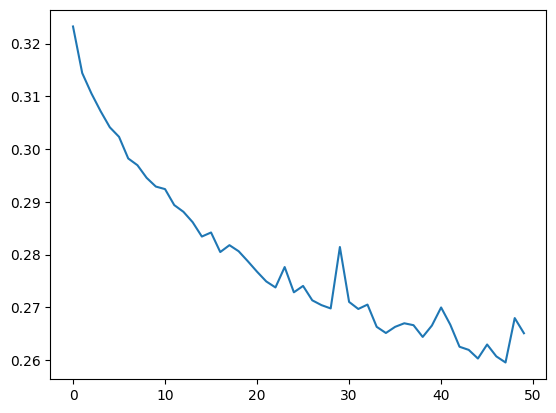

In [38]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes.

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability.
Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The `temperature` parameter can be used to control the randomness of notes generated. You can find more details on temperature in [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

In [39]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [48]:
temperature = 3.1
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

In [49]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,49,0.086620,0.124429,0.086620,0.211050
1,97,0.181276,1.153087,0.267897,1.420984
2,92,0.203657,1.366467,0.471553,1.838021
3,97,0.203974,1.390638,0.675528,2.066166
4,77,0.204518,1.405774,0.880046,2.285820
5,97,0.205295,1.437144,1.085341,2.522484
6,87,0.205822,1.437604,1.291163,2.728767
7,97,0.205958,1.446520,1.497122,2.943641
8,96,0.206382,1.450485,1.703504,3.153989
9,92,0.206713,1.459455,1.910217,3.369672


In [50]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

You can also download the audio file by adding the two lines below:

```
from google.colab import files
files.download(out_file)
```

Visualize the generated notes.

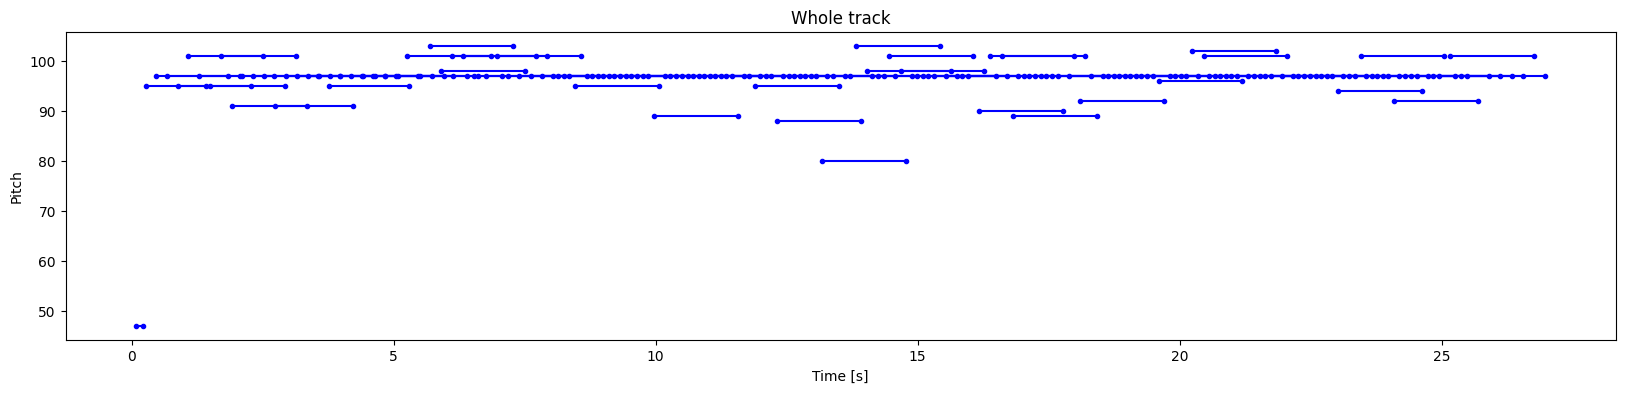

In [43]:
plot_piano_roll(generated_notes)

Check the distributions of `pitch`, `step` and `duration`.

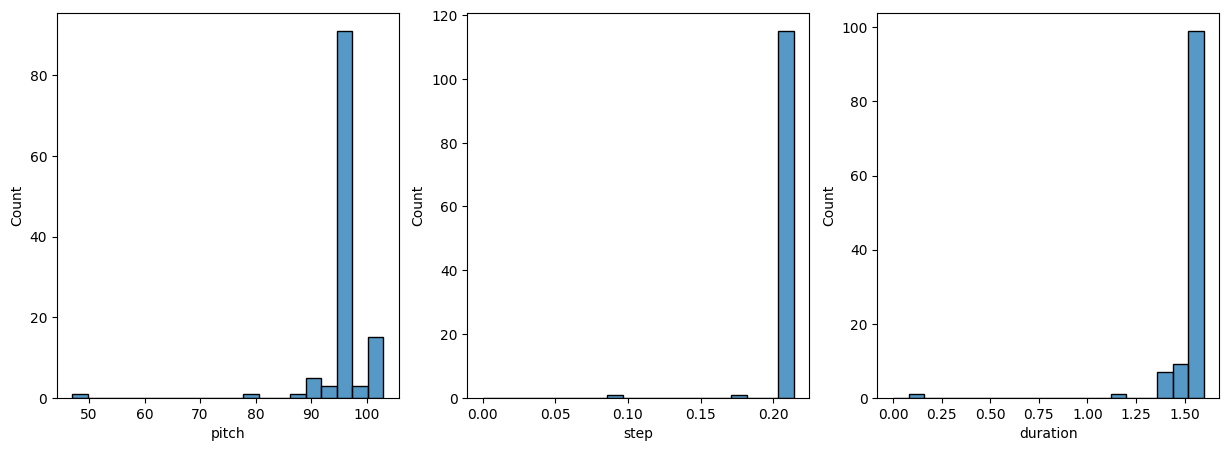

In [44]:
plot_distributions(generated_notes)

In the above plots, you will notice the change in distribution of the note variables.
Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss.
This is particularly relevant for `step` and `duration`, which uses the MSE loss.
For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.


## Next steps

This tutorial demonstrated the mechanics of using an RNN to generate sequences of notes from a dataset of MIDI files. To learn more, you can visit the closely related [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial, which contains additional diagrams and explanations.

One of the alternatives to using RNNs for music generation is using GANs. Rather than generating audio, a GAN-based approach can generate an entire sequence in parallel. The Magenta team has done impressive work on this approach with [GANSynth](https://magenta.tensorflow.org/gansynth). You can also find many wonderful music and art projects and open-source code on [Magenta project website](https://magenta.tensorflow.org/).